In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import cv2
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split

from tqdm import tqdm
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, Input
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import load_model

In [ ]:
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
df_generated = pd.read_csv('/content/drive/MyDrive/Fairfake - ASDRP/Experiments/gender-with-fakes/df_generated_only.csv')

In [ ]:
df_generated.shape

(8410, 4)

In [ ]:
df_generated['race'].value_counts()

1    2460
4    2140
3    1962
2    1848
Name: race, dtype: int64

In [ ]:
df_imbalanced = pd.read_csv('/content/drive/MyDrive/Fairfake - ASDRP/Experiments/simple-cnn-v3/df.csv')

In [ ]:
df_imbalanced['age'] = np.where((df_imbalanced['age'] >= 0) & (df_imbalanced['age'] <= 2), 0, df_imbalanced['age'])
df_imbalanced['age'] = np.where((df_imbalanced['age'] >= 3) & (df_imbalanced['age'] <= 9), 1, df_imbalanced['age'])
df_imbalanced['age'] = np.where((df_imbalanced['age'] >= 10) & (df_imbalanced['age'] <= 19), 2, df_imbalanced['age'])
df_imbalanced['age'] = np.where((df_imbalanced['age'] >= 20) & (df_imbalanced['age'] <= 29), 3, df_imbalanced['age'])
df_imbalanced['age'] = np.where((df_imbalanced['age'] >= 30) & (df_imbalanced['age'] <= 39), 4, df_imbalanced['age'])
df_imbalanced['age'] = np.where((df_imbalanced['age'] >= 40) & (df_imbalanced['age'] <= 49), 5, df_imbalanced['age'])
df_imbalanced['age'] = np.where((df_imbalanced['age'] >= 50) & (df_imbalanced['age'] <= 59), 6, df_imbalanced['age'])
df_imbalanced['age'] = np.where((df_imbalanced['age'] >= 60) & (df_imbalanced['age'] <= 69), 7, df_imbalanced['age'])
df_imbalanced['age'] = np.where(df_imbalanced['age'] >= 70, 8, df_imbalanced['age'])

In [ ]:
df_imbalanced['race'].value_counts()

0    2682
2     834
3     720
4     542
1     222
Name: race, dtype: int64

In [ ]:
def load(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    #img = tf.image.resize(img, size=(64, 64))
    return img


In [ ]:
fake_images = [load(i) for i in tqdm(df_generated.image)]

Streaming output truncated to the last 5000 lines.
100%|██████████| 8410/8410 [1:02:16<00:00,  2.25it/s]


In [ ]:
with open('/content/drive/MyDrive/ASDRP/Experiments/gender-with-fakes/fake_images.pickle', 'wb') as handle:
  pickle.dump(fake_images, handle)

In [ ]:
real_images = pickle.load(open("/content/drive/MyDrive/ASDRP/Experiments/simple-cnn-v3/list_of_tensors_generated.pickle", "rb"))

In [ ]:
images = real_images + fake_images

In [ ]:
len(images)

13410

In [ ]:
with open('/content/drive/MyDrive/ASDRP/Experiments/gender-with-fakes/all_images.pickle', 'wb') as handle:
  pickle.dump(images, handle)

In [ ]:
df_all = df_imbalanced.append(df_generated, ignore_index=True)

In [ ]:
df_all.to_csv(r'drive/My Drive/ASDRP/Experiments/gender-with-fakes/df_all.csv', index = False, header=True)

In [ ]:
df_all = pd.read_csv('drive/My Drive/Fairfake - ASDRP/Experiments/gender-with-fakes/df_all.csv')

In [ ]:
images = pickle.load(open("/content/drive/MyDrive/ASDRP/Experiments/gender-with-fakes/all_images.pickle", "rb"))

In [ ]:
df_all['gender'].value_counts()

1    6984
0    6426
Name: gender, dtype: int64

In [ ]:
df_all.iloc[10000]

image     drive/My Drive/ASDRP/generated_images/4_0_3_51...
age                                                       4
gender                                                    0
race                                                      3
Name: 10000, dtype: object

In [ ]:
len(df_all[df_all['image'].str.endswith('png')])

1622

In [ ]:
df_generated['race'].value_counts()

1    2460
4    2140
3    1962
2    1848
Name: race, dtype: int64

In [ ]:
df_all[df_all['image'].str.endswith('png')].shape

(8410, 5)

In [ ]:
indices = []
female_total = 1313


for i in tqdm(range(len(df_all))):
  if df_all.iloc[i]['gender'] == 1 and df_all.iloc[i]['race'] != 0 and df_all.iloc[i]['image'].endswith('jpg') and female_total > 500:
    indices.append(i)
    female_total -= 1
  


100%|██████████| 13410/13410 [00:02<00:00, 5486.67it/s]


In [ ]:
df_all = df_all.drop(indices)
df_all = df_all.reset_index()

In [ ]:
df_all[df_all['image'].str.endswith('jpg')]['gender'].value_counts()

0    2248
1    1939
Name: gender, dtype: int64

In [ ]:
'''fake_indices = []
black_total = 2460
asian_total = 1848
indian_total = 1962
others_total = 2140

for i in tqdm(range(len(df_all))):
  if df_all.iloc[i]['race'] == 1 and df_all.iloc[i]['image'].endswith('png') and black_total > 800:
    fake_indices.append(i)
    black_total -= 1

  if df_all.iloc[i]['race'] == 2 and df_all.iloc[i]['image'].endswith('png') and asian_total > 800:
    fake_indices.append(i)
    asian_total -= 1

  if df_all.iloc[i]['race'] == 3 and df_all.iloc[i]['image'].endswith('png') and indian_total > 800:
    fake_indices.append(i)
    indian_total -= 1

  if df_all.iloc[i]['race'] == 4 and df_all.iloc[i]['image'].endswith('png') and others_total > 800:
    fake_indices.append(i)
    others_total -= 1
'''

100%|██████████| 13410/13410 [00:14<00:00, 920.62it/s]


In [ ]:
images_reduced = []

for i in range(len(images)):
  if i not in indices:
    images_reduced.append(images[i])

In [ ]:
len(images_reduced)

12597

In [ ]:
df_all['race'].value_counts()

0    2682
1    2640
4    2550
2    2461
3    2264
Name: race, dtype: int64

In [ ]:
# dropping some fake images to avoid overfitting
# indices = df_all[df_all['image'].str.endswith('png')].sample(7410).index

#black_count = len(df_all[df_all['race'] == 1])
#asian_count = len(df_all[df_all['race'] == 2])
#indian_count = len(df_all[df_all['race'] == 3])
#others_count = len(df_all[df_all['race'] == 4])

#for i in tqdm(range(len(df_all))):
#
#  if df_all.iloc[i]['image'].endswith('png') and len(indices) < 7410:
#    indices.append(i)

In [ ]:
#df_all = df_all.drop(indices)
#df_all = df_all.reset_index()

In [ ]:
df_all['race'].value_counts()

0    2682
1    2640
4    2550
2    2461
3    2264
Name: race, dtype: int64

In [ ]:
#images = [i for j, i in enumerate(images) if j not in indices]

In [ ]:
len(images)

13410

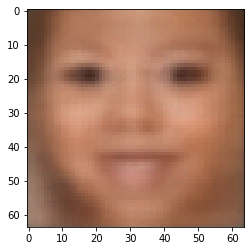

In [ ]:
from matplotlib import pyplot as plt

plt.imshow((images_reduced[5000]), interpolation='nearest')
plt.show()

In [ ]:
# df_notwhite = df_all[(df_all['race'] != 0) & (df_all['image'].str.endswith('jpg'))]

In [ ]:
# df_notwhite.shape

(2318, 4)

In [ ]:
# flipped_images = []

In [ ]:
#for i in tqdm(df_notwhite.index):
#  flipped_images.append(np.fliplr(images[i]))

100%|██████████| 2318/2318 [00:00<00:00, 7238.33it/s]


In [ ]:
#df_all = df_all.append(df_notwhite, ignore_index=True)

In [ ]:
#df_all.tail()

,image,age,gender,race
15723,drive/My Drive/ASDRP/Data/utk_cropped/part1/52...,6,1,1
15724,drive/My Drive/ASDRP/Data/utk_cropped/part1/53...,6,1,1
15725,drive/My Drive/ASDRP/Data/utk_cropped/part1/65...,7,1,1
15726,drive/My Drive/ASDRP/Data/utk_cropped/part1/53...,6,1,1
15727,drive/My Drive/ASDRP/Data/utk_cropped/part1/69...,7,1,4


In [ ]:
#images = images + flipped_images

In [ ]:
df_all['race'].value_counts()

0    2682
2    1759
3    1700
4    1620
1    1471
Name: race, dtype: int64

In [ ]:
df_all['gender'].value_counts()

0    6426
1    6171
Name: gender, dtype: int64

In [ ]:
df_all['age'].value_counts()

0    2154
1    1988
2    1936
4    1869
3    1853
5    1672
6     446
8     363
7     316
Name: age, dtype: int64

In [ ]:
race_dict = {'WM':0, 'BM': 0, 'AM': 0, 'IM': 0, 'OM': 0, 'WF':0, 'BF': 0, 'AF': 0, 'IF': 0, 'OF': 0}
for i in tqdm(range(len(df_all))):
  if df_all.iloc[i]['gender'] == 0:
    if df_all.iloc[i]['race'] == 0:
      race_dict['WM'] += 1
    if df_all.iloc[i]['race'] == 1:
      race_dict['BM'] += 1
    if df_all.iloc[i]['race'] == 2:
      race_dict['AM'] += 1
    if df_all.iloc[i]['race'] == 3:
      race_dict['IM'] += 1
    if df_all.iloc[i]['race'] == 4:
      race_dict['OM'] += 1
  else:
    if df_all.iloc[i]['race'] == 0:
      race_dict['WF'] += 1
    if df_all.iloc[i]['race'] == 1:
      race_dict['BF'] += 1
    if df_all.iloc[i]['race'] == 2:
      race_dict['AF'] += 1
    if df_all.iloc[i]['race'] == 3:
      race_dict['IF'] += 1
    if df_all.iloc[i]['race'] == 4:
      race_dict['OF'] += 1
  

 

100%|██████████| 12597/12597 [00:08<00:00, 1449.51it/s]


Text(0, 0.5, 'Number of examples in dataset')

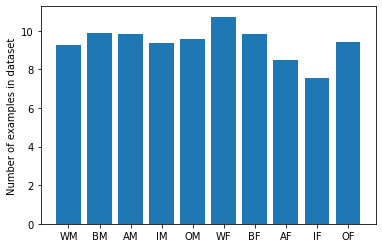

In [ ]:
names = list(race_dict.keys())
values = list(race_dict.values())

for i in range(len(values)):
  values[i] /= 13410
  values[i] *= 100

plt.bar(range(len(race_dict)), values, tick_label=names)

plt.ylabel("Number of examples in dataset")

In [ ]:
values

[9.269202087994035,
 9.865771812080537,
 9.843400447427292,
 9.343773303504847,
 9.59731543624161,
 10.730797912005965,
 9.82102908277405,
 8.508575689783743,
 7.539149888143176,
 9.41834451901566]

In [ ]:
df_all.shape

(12597, 5)

In [ ]:
df_all.shape

(12597, 5)

In [ ]:
#weights = {0:1, 1:1.5}
#validation['weights'] = validation['gender'].apply(lambda x: weights[x])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#validation['weights'] = np.where(validation['gender'] == 1, 10, validation['weights'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
#validation['weights'].value_counts()

1.5    1852
1.0    1630
Name: weights, dtype: int64

In [ ]:
#val_indices = validation.sample(n=2378, weights='weights', random_state=42).index

In [ ]:
input_shape = (64, 64, 3)

In [ ]:
y_gender = [i for i in df_all['gender']]
y_race = [i for i in df_all['race']]

In [ ]:
y_stack = np.vstack((y_gender,y_race))
Y = y_stack[0]

In [ ]:
val_images = pickle.load(open("/content/drive/MyDrive/ASDRP/Experiments/simple-cnn-v3/test_tensors_generated.pickle", "rb"))

In [ ]:
df_val = pd.read_csv('/content/drive/MyDrive/Fairfake - ASDRP/Experiments/df_test.csv')  

In [ ]:
Y_val = np.array(df_val['gender'])

In [ ]:
test = df_all[df_all['image'].str.endswith('jpg')]

In [ ]:
test.shape

(4187, 5)

In [ ]:
test['gender'].value_counts()

0    2248
1    1939
Name: gender, dtype: int64

In [ ]:
test_indices = test.sample(n=837, random_state=40).index

In [ ]:
test_images = []
for i in test_indices.tolist():
  test_images.append(images_reduced[i])

In [ ]:
y_gender_test = np.array(df_all.iloc[test_indices]['gender'])

In [ ]:
len(images_reduced)

9635

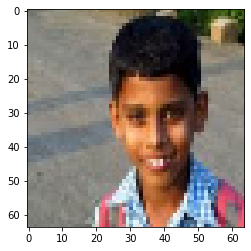

In [ ]:
plt.imshow((images_reduced[4]), interpolation='nearest')
plt.show()

In [ ]:
images_reduced = [i for j, i in enumerate(images_reduced) if j not in test_indices.tolist()]

In [ ]:
Y = np.delete(Y, test_indices.tolist())

In [ ]:
'''
men_indices = []
for i in range(len(df_all.drop(test_indices).reset_index())):
  if df_all.iloc[i]['gender'] == 0 and df_all.iloc[i]['image'].endswith('jpg'):
    men_indices.append(i)
'''

In [ ]:
images_reduced = [i for j, i in enumerate(images_reduced) if j not in men_indices]
Y = np.delete(Y, men_indices)

In [ ]:
images_reduced = np.array(images_reduced)
val_images = np.array(val_images)

In [ ]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
#dense_2 = Dense(256, activation='relu') (flatten)
#dense_3 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
#dropout_2 = Dropout(0.3) (dense_2)
#dropout_3 = Dropout(0.3) (dense_3)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
#output_2 = Dense(1, activation='softmax', name='race_out') (dropout_2)
#output_3 = Dense(1, activation='relu', name='age_out') (dropout_3)

model = Model(inputs=[inputs], outputs=[output_1])

model.compile(loss=['binary_crossentropy'], optimizer='adam', metrics=['accuracy'])

In [ ]:
#from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
#datagen = ImageDataGenerator(brightness_range=[0.3,0.9])

In [ ]:
#it = datagen.flow(images, Y)

In [ ]:
#datagen.fit(images)

In [ ]:
len(images)

10078

In [ ]:
model2 = load_model('drive/My Drive/ASDRP/Model Checkpoints/unbalanced_final.h5')

In [ ]:
model.set_weights(model2.get_weights())

In [ ]:
#history = model.fit_generator(it, steps_per_epoch = 314, epochs = 10, validation_data=(val_images, Y_val))

In [ ]:
history = model.fit(x=images_reduced, y=Y, batch_size=32, epochs=20, validation_data=(val_images, Y_val))

Epoch 1/20
298/298 [==============================] - 3s 7ms/step - loss: 0.0780 - accuracy: 0.9736 - val_loss: 2.0715 - val_accuracy: 0.6950
Epoch 2/20
298/298 [==============================] - 2s 6ms/step - loss: 0.0198 - accuracy: 0.9938 - val_loss: 2.0613 - val_accuracy: 0.6820
Epoch 3/20
298/298 [==============================] - 2s 6ms/step - loss: 0.0152 - accuracy: 0.9948 - val_loss: 2.3041 - val_accuracy: 0.6040
Epoch 4/20
298/298 [==============================] - 2s 6ms/step - loss: 0.0071 - accuracy: 0.9977 - val_loss: 1.8696 - val_accuracy: 0.6900
Epoch 5/20
298/298 [==============================] - 2s 7ms/step - loss: 0.0219 - accuracy: 0.9924 - val_loss: 1.4847 - val_accuracy: 0.6830
Epoch 6/20
298/298 [==============================] - 2s 6ms/step - loss: 0.0158 - accuracy: 0.9939 - val_loss: 1.9489 - val_accuracy: 0.6420
Epoch 7/20
298/298 [==============================] - 2s 7ms/step - loss: 0.0059 - accuracy: 0.9979 - val_loss: 1.8795 - val_accuracy: 0.6930
Epoch 

In [ ]:
model.save("drive/My Drive/ASDRP/Model Checkpoints/synthetic_balanced3.h5")

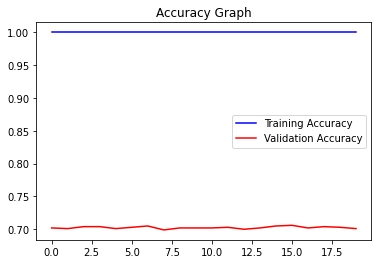

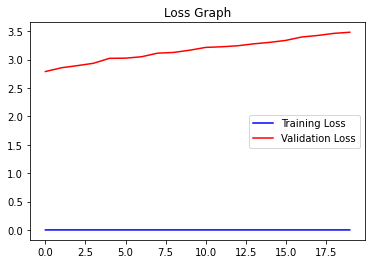

In [ ]:
# plot results for gender
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [ ]:
model = load_model('drive/My Drive/ASDRP/Model Checkpoints/unbalanced_reduced.h5')

Original Gender: 0
Predicted Gender: 0


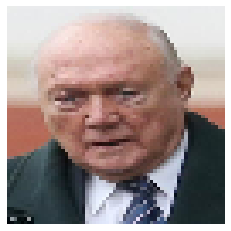

In [ ]:
image_index = 400
print("Original Gender:", Y_val[image_index])
# predict from model
pred = model.predict(val_images[image_index].reshape(1, 64, 64, 3))
pred_gender = round(pred[0][0])
#pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender)
plt.axis('off')
plt.imshow(val_images[image_index].reshape(64, 64, 3));

In [ ]:
test_images = np.array(test_images)

In [ ]:
#df_everything = pd.read_csv('drive/My Drive/ASDRP/Data/df_everything.csv')

In [ ]:
#common = df_all.merge(df_everything,on=['image'])

In [ ]:
#df_everything[(~df_everything.image.isin(common.image))]

,image,age,gender,race
0,drive/My Drive/ASDRP/Data/UTKFace/56_0_0_20170...,6,0,0
1,drive/My Drive/ASDRP/Data/UTKFace/56_0_3_20170...,6,0,3
2,drive/My Drive/ASDRP/Data/UTKFace/56_0_3_20170...,6,0,3
3,drive/My Drive/ASDRP/Data/UTKFace/56_0_3_20170...,6,0,3
4,drive/My Drive/ASDRP/Data/UTKFace/56_0_3_20170...,6,0,3
...,...,...,...,...
23700,drive/My Drive/ASDRP/Data/UTKFace/1_0_2_201612...,0,0,2
23701,drive/My Drive/ASDRP/Data/UTKFace/1_0_0_201612...,0,0,0
23702,drive/My Drive/ASDRP/Data/UTKFace/1_0_2_201612...,0,0,2
23703,drive/My Drive/ASDRP/Data/UTKFace/5_0_2_201612...,1,0,2


In [ ]:
#test_images = pickle.load(open("/content/drive/MyDrive/ASDRP/Experiments/simple-cnn-v3/test_tensors_generated.pickle", "rb"))
#test_images = np.array(test_images)

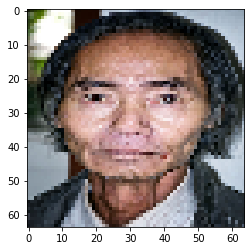

In [ ]:
from matplotlib import pyplot as plt

plt.imshow((test_images[15]), interpolation='nearest')
plt.show()

In [ ]:
predictions_gender = []
for i in tqdm(test_images):
  pred = model.predict(i.reshape(1, 64, 64, 3))
  pred_gender = round(pred[0][0])
  predictions_gender.append(pred_gender)

100%|██████████| 837/837 [00:34<00:00, 24.26it/s]


In [ ]:
df_test = df_all.iloc[test_indices].reset_index()

In [ ]:
def get_accuracy_both(race, gender):
  correct = 0
  total = 0
  for i in range(837):
    if predictions_gender[i] == y_gender_test[i] and df_test.iloc[i]['race'] == race and df_test.iloc[i]['gender'] == gender: 
      correct += 1
    if df_test.iloc[i]['race'] == race and df_test.iloc[i]['gender'] == gender:
      total += 1
    #if df_test.iloc[i]['race'] == race and df_test.iloc[i]['gender'] == gender and df_test.iloc[i]['age'] >= age_start and df_test.iloc[i]['age'] <= age_end:
    #  total += 1

    #  and df_test.iloc[i]['race'] == race and df_test.iloc[i]['gender'] == gender and df_test.iloc[i]['age'] >= age_start and df_test.iloc[i]['age'] <= age_end
  
  return correct / total

In [ ]:
def get_accuracy_race(race):
  correct = 0
  total = 0
  for i in range(837):
    if predictions_gender[i] == y_gender_test[i] and df_test.iloc[i]['race'] == race: 
      correct += 1
    if df_test.iloc[i]['race'] == race:
      total += 1
  
  return correct / total

In [ ]:
def get_accuracy_gender(gender):
  correct = 0
  total = 0
  for i in range(837):
    if predictions_gender[i] == y_gender_test[i] and df_test.iloc[i]['gender'] == gender: 
      correct += 1
    if df_test.iloc[i]['gender'] == gender:
      total += 1
  
  return correct / total

In [ ]:
def get_accuracy_overall():
  correct = 0
  total = 837
  for i in range(837):
    if predictions_gender[i] == y_gender_test[i]: 
      correct += 1
  
  return correct / total

In [ ]:
def get_false_positive(race):
  false_positives = 0
  total = 0
  for i in range(837):
    if predictions_gender[i] == 1 and y_gender_test[i] == 0 and df_test.iloc[i]['race'] == race: 
      false_positives += 1
    if df_test.iloc[i]['race'] == race:
      total += 1
  
  return false_positives / total

In [ ]:
def get_false_negative(race):
  false_negatives = 0
  total = 0
  for i in range(837):
    if predictions_gender[i] == 0 and y_gender_test[i] == 1 and df_test.iloc[i]['race'] == race: 
      false_negatives += 1
    if df_test.iloc[i]['race'] == race:
      total += 1
  
  return false_negatives / total

In [ ]:
predictions_gender[10:20]

[1, 1, 0, 0, 0, 0, 1, 0, 0, 0]

In [ ]:
y_gender_test[10:20]

array([1, 1, 0, 0, 1, 0, 0, 1, 0, 0])

In [ ]:
get_accuracy_overall()

0.7347670250896058

In [ ]:
get_accuracy_both(4, 1)

0.64

In [ ]:
get_accuracy_gender(0)

0.765625

In [ ]:
get_accuracy_race(0)

0.8453237410071942

In [ ]:
get_false_positive(4)

0.15

In [ ]:
get_false_negative(4)

0.2

# original way

In [ ]:
y_gender = [i for i in df_all['gender']]
y_race = [i for i in df_all['race']]

In [ ]:
len(y_gender)

9232

In [ ]:
y_stack = np.vstack((y_gender,y_race))

In [ ]:
#from sklearn.model_selection import train_test_split
#X, X_test, Y, y_test = train_test_split(images, y_stack[0], test_size=0.2, random_state = 42)
X = images
Y = y_stack[0]

In [ ]:
Y_alias = y_stack[1]

In [ ]:
#X_alias, X_alias2, Y_alias, y_alias2 = train_test_split(gen_images, y_stack[1], test_size=0.2, random_state = 42)

In [ ]:
def create_new_model():
  model = tf.keras.applications.efficientnet.EfficientNetB0(
      include_top=True,
      weights=None,
      input_tensor=None,
      input_shape=(64,64,3),
      pooling=None,
      classes=1,
      classifier_activation='sigmoid',
  )
  return model
  

In [ ]:
def get_model_name(k):
    return 'model_less'+str(k)+'.h5'

Epoch 1/40
157/157 [==============================] - ETA: 0s - loss: 2.6548 - accuracy: 0.5127
Epoch 1: val_accuracy improved from -inf to 0.54428, saving model to /content/drive/MyDrive/ASDRP/Experiments/gender-with-fakes/model_less1.h5
157/157 [==============================] - 21s 77ms/step - loss: 2.6548 - accuracy: 0.5127 - val_loss: 0.8046 - val_accuracy: 0.5443
Epoch 2/40
157/157 [==============================] - ETA: 0s - loss: 1.4029 - accuracy: 0.5099
Epoch 2: val_accuracy did not improve from 0.54428
157/157 [==============================] - 9s 60ms/step - loss: 1.4029 - accuracy: 0.5099 - val_loss: 0.6910 - val_accuracy: 0.5443
Epoch 3/40
156/157 [============================>.] - ETA: 0s - loss: 1.3632 - accuracy: 0.5286
Epoch 3: val_accuracy did not improve from 0.54428
157/157 [==============================] - 8s 49ms/step - loss: 1.3645 - accuracy: 0.5285 - val_loss: 0.6972 - val_accuracy: 0.4557
Epoch 4/40
156/157 [============================>.] - ETA: 0s - loss: 

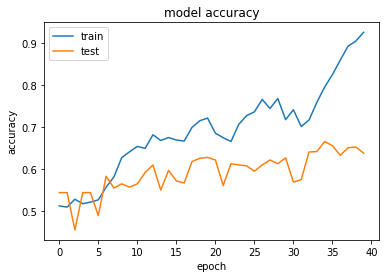

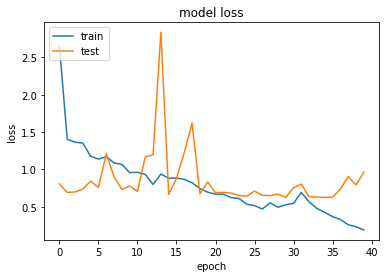

32/32 [==============================] - 0s 14ms/step - loss: 0.6235 - accuracy: 0.6657


Exception ignored in: <function ScopedTFGraph.__del__ at 0x7f424b881680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/c_api_util.py", line 53, in __del__
    def __del__(self):
KeyboardInterrupt


Epoch 1/40


Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7f4245c17560>
Traceback (most recent call last):
  File "/usr/lib/python3.7/weakref.py", line 358, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt


110/157 [====================>.........] - ETA: 2s - loss: 3.1000 - accuracy: 0.5145

KeyboardInterrupt: ignored

In [ ]:
VALIDATION_ACCURACY = []
VALIDATION_LOSS = []


save_dir = '/content/drive/MyDrive/ASDRP/Experiments/gender-with-fakes/'
fold_var = 1

from sklearn.model_selection import KFold, StratifiedKFold

skf = StratifiedKFold(5, random_state = 7, shuffle = True) 

for train_index,val_index in skf.split(X,Y):
  #train = df_all.iloc[train_index]
  #print(train['gender'].value_counts())

  validation = df_all.iloc[val_index]
  validation.index = val_index

  add_to_train = validation[validation['image'].str.endswith('png')]
  add_index = add_to_train.index
  
  train_index = np.append(train_index, add_index)

  validation = validation[~validation['image'].str.endswith('png')]
  val_index = validation.index

  #duplicate_indices = []

  #for i in train_index:
  #  if df_all.iloc[i]['race'] != 0 and df_all.iloc[i]['image'].endswith('jpg'):
  #    duplicate_indices.append(i)
  
  #train_index = np.append(train_index, duplicate_indices)


  

  x_train,x_val= X[train_index],X[val_index]
  y_train,y_val=Y[train_index],Y[val_index]

  model = create_new_model()

  model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

  checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold_var), 
							monitor='val_accuracy', verbose=1, 
							save_best_only=True, mode='max')
  
  callbacks_list = [checkpoint]
  
  history = model.fit(x=x_train, y=y_train, batch_size=32, epochs=40, shuffle=True, callbacks=callbacks_list, validation_data = (x_val,y_val))
  
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  model.load_weights("/content/drive/MyDrive/ASDRP/Experiments/gender-with-fakes/model_less"+str(fold_var)+".h5")
  
  results = model.evaluate(x=x_val, y=y_val)
  results = dict(zip(model.metrics_names,results))
	
  VALIDATION_ACCURACY.append(results['accuracy'])
  VALIDATION_LOSS.append(results['loss'])
  tf.keras.backend.clear_session()

  
  fold_var+=1

In [ ]:
print(VALIDATION_ACCURACY)

[0.6656716465950012]


In [ ]:
model = create_new_model()
model.load_weights("/content/drive/MyDrive/ASDRP/Experiments/gender-with-fakes/model_less1.h5")
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])


In [ ]:
df_test = pd.read_csv('/content/drive/MyDrive/ASDRP/Experiments/df_test.csv')  

In [ ]:
test_images = [load(i) for i in tqdm(df_sub.image)]



  0%|          | 0/1300 [00:00<?, ?it/s]

  0%|          | 1/1300 [00:00<15:44,  1.38it/s]

  0%|          | 2/1300 [00:01<10:35,  2.04it/s]

  0%|          | 3/1300 [00:01<08:46,  2.46it/s]

  0%|          | 4/1300 [00:01<07:34,  2.85it/s]

  0%|          | 5/1300 [00:02<07:54,  2.73it/s]

  0%|          | 6/1300 [00:02<08:27,  2.55it/s]

  1%|          | 7/1300 [00:02<08:12,  2.63it/s]

  1%|          | 8/1300 [00:03<08:05,  2.66it/s]

  1%|          | 9/1300 [00:03<07:38,  2.82it/s]

  1%|          | 10/1300 [00:03<07:36,  2.83it/s]

  1%|          | 11/1300 [00:04<08:01,  2.68it/s]

  1%|          | 12/1300 [00:04<08:19,  2.58it/s]

  1%|          | 13/1300 [00:05<07:53,  2.72it/s]

  1%|          | 14/1300 [00:05<07:29,  2.86it/s]

  1%|          | 15/1300 [00:05<06:52,  3.11it/s]

  1%|          | 16/1300 [00:05<06:34,  3.25it/s]

  1%|▏         | 17/1300 [00:06<06:25,  3.32it/s]

  1%|▏         | 18/1300 [00:06<06:10,  3.46it/s]

  1%|▏         | 19/1300 [00:06<07:00,  3.05it/

In [ ]:
#with open('/content/drive/MyDrive/ASDRP/Experiments/Imbalanced Race for Gender Classification/test_tensors.pickle', 'wb') as handle:
#  pickle.dump(test_images, handle)

In [ ]:
test_images = pickle.load(open("/content/drive/MyDrive/ASDRP/Experiments/simple-cnn-v3/test_tensors_generated.pickle", "rb"))

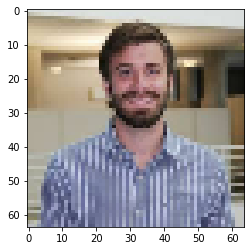

In [ ]:
from matplotlib import pyplot as plt

plt.imshow(test_images[215], interpolation='nearest')
plt.show()

In [ ]:
test_gender = [i for i in df_test.gender]
test_race = [i for i in df_test.race]

In [ ]:
len(test_gender)

1000

In [ ]:
from sklearn.metrics import confusion_matrix
import keras
race_total = {'White':0, 'Black': 0, 'Asian': 0, 'Indian': 0, 'Others': 0, 'White F':0, 'Black F': 0, 'Asian F': 0, 'Indian F': 0, 'Others F': 0}
race_correct = {'White':0, 'Black': 0, 'Asian': 0, 'Indian': 0, 'Others': 0, 'White F':0, 'Black F': 0, 'Asian F': 0, 'Indian F': 0, 'Others F': 0}
false_positives = {'White':0, 'Black': 0, 'Asian': 0, 'Indian': 0, 'Others': 0}
loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
test_acc_metric = keras.metrics.BinaryAccuracy()
list2 = []
predictions = []

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_gender))
test_dataset = test_dataset.batch(1)
for step, (x_batch_test, y_batch_test) in enumerate(test_dataset):
  if test_gender[step] == 0:
    if test_race[step] == 0:
        race_total['White'] += 1
    elif test_race[step] == 1:
        race_total['Black'] += 1
    elif test_race[step] == 2:
        race_total['Asian'] += 1
    elif test_race[step] == 3:
        race_total['Indian'] += 1  
    elif test_race[step] == 4:
        race_total['Others'] += 1
  else:
    if test_race[step] == 0:
        race_total['White F'] += 1
    elif test_race[step] == 1:
        race_total['Black F'] += 1
    elif test_race[step] == 2:
        race_total['Asian F'] += 1
    elif test_race[step] == 3:
        race_total['Indian F'] += 1  
    elif test_race[step] == 4:
        race_total['Others F'] += 1
  with tf.GradientTape() as tape:
    logits = model(x_batch_test, training=False)
    if logits >= 0.5:
      predictions.append(1)
    else:
      predictions.append(0)
    loss_value = loss_fn(y_batch_test,logits)
    test_acc_metric.update_state(y_batch_test, logits)
    list2.append(test_acc_metric.result().numpy())

  if step >= 1:
    if list2[step] >= list2[step-1]:
      if test_gender[step] == 0:
        if test_race[step] == 0:
          race_correct['White'] += 1
        elif test_race[step] == 1:
          race_correct['Black'] += 1
        elif test_race[step] == 2:
          race_correct['Asian'] += 1
        elif test_race[step] == 3:
          race_correct['Indian'] += 1
        elif test_race[step] == 4:
          race_correct['Others'] += 1
      else:
        if test_race[step] == 0:
          race_correct['White F'] += 1
        elif test_race[step] == 1:
          race_correct['Black F'] += 1
        elif test_race[step] == 2:
          race_correct['Asian F'] += 1
        elif test_race[step] == 3:
          race_correct['Indian F'] += 1
        elif test_race[step] == 4:
          race_correct['Others F'] += 1
    else:
      if test_gender[step] == 0 and predictions[step] == 1:
        if test_race[step] == 0:
          false_positives['White'] += 1
        elif test_race[step] == 1:
          false_positives['Black'] += 1
        elif test_race[step] == 2:
          false_positives['Asian'] += 1
        elif test_race[step] == 3:
          false_positives['Indian'] += 1
        elif test_race[step] == 4:
          false_positives['Others'] += 1   


  if step % 100 == 0:
            print(
                "Testing loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %s samples" % ((step + 1)))

test_acc = test_acc_metric.result()
print("Testing acc %.4f" % (float(test_acc),))


Testing loss (for one batch) at step 0: 0.5670
Seen so far: 1 samples
Testing loss (for one batch) at step 100: 0.9347
Seen so far: 101 samples
Testing loss (for one batch) at step 200: 0.9527
Seen so far: 201 samples
Testing loss (for one batch) at step 300: 0.4762
Seen so far: 301 samples
Testing loss (for one batch) at step 400: 0.8802
Seen so far: 401 samples
Testing loss (for one batch) at step 500: 1.2219
Seen so far: 501 samples
Testing loss (for one batch) at step 600: 0.7148
Seen so far: 601 samples
Testing loss (for one batch) at step 700: 1.2674
Seen so far: 701 samples
Testing loss (for one batch) at step 800: 0.5178
Seen so far: 801 samples
Testing loss (for one batch) at step 900: 1.1806
Seen so far: 901 samples
Testing acc 0.6490


In [ ]:
df_test['gender'].value_counts()

1    550
0    450
Name: gender, dtype: int64

In [ ]:
race_total

{'Asian': 100,
 'Asian F': 100,
 'Black': 101,
 'Black F': 99,
 'Indian': 73,
 'Indian F': 127,
 'Others': 95,
 'Others F': 105,
 'White': 81,
 'White F': 119}

In [ ]:
race_correct

{'Asian': 47,
 'Asian F': 71,
 'Black': 59,
 'Black F': 68,
 'Indian': 38,
 'Indian F': 94,
 'Others': 49,
 'Others F': 81,
 'White': 55,
 'White F': 88}

In [ ]:
for i in race_total:
  print(f'Percentage of {i} class in testing dataset: {round(race_total[i]/sum(race_total.values()), 2) * 100} %')
  print(f'Testing accuracy of {i} class: {round(float(race_correct[i] / race_total[i]),3) * 100} %')

Percentage of White class in testing dataset: 8.0 %
Testing accuracy of White class: 67.9 %
Percentage of Black class in testing dataset: 10.0 %
Testing accuracy of Black class: 58.4 %
Percentage of Asian class in testing dataset: 10.0 %
Testing accuracy of Asian class: 47.0 %
Percentage of Indian class in testing dataset: 7.000000000000001 %
Testing accuracy of Indian class: 52.1 %
Percentage of Others class in testing dataset: 10.0 %
Testing accuracy of Others class: 51.6 %
Percentage of White F class in testing dataset: 12.0 %
Testing accuracy of White F class: 73.9 %
Percentage of Black F class in testing dataset: 10.0 %
Testing accuracy of Black F class: 68.7 %
Percentage of Asian F class in testing dataset: 10.0 %
Testing accuracy of Asian F class: 71.0 %
Percentage of Indian F class in testing dataset: 13.0 %
Testing accuracy of Indian F class: 74.0 %
Percentage of Others F class in testing dataset: 10.0 %
Testing accuracy of Others F class: 77.10000000000001 %


In [ ]:
for i in false_positives:
  false_positives[i] = false_positives[i] / race_total[i]

In [ ]:
false_positives

{'Asian': 0.54,
 'Black': 0.4752475247524752,
 'Indian': 0.5205479452054794,
 'Others': 0.5578947368421052,
 'White': 0.3950617283950617}

Text(0, 0.5, 'False Positive Rate')

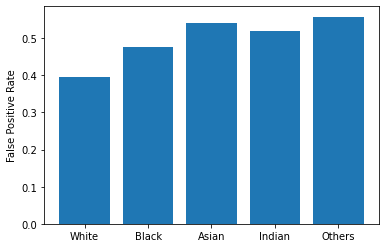

In [ ]:
names = list(false_positives.keys())
values = list(false_positives.values())

plt.bar(range(len(false_positives)), values, tick_label=names)

plt.ylabel("False Positive Rate")

In [ ]:
new_images = []
new_genders = []
new_races = []
